In [1]:
!pip install -q torchview

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchview import draw_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os

In [3]:
device = torch.device('cuda')

In [4]:
def plot_images(tensor_list, grid_size):
    num_tensors = len(tensor_list)
    num_rows = grid_size
    num_cols = int(1 + num_tensors / num_rows) - 1
    _, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i, tensor in enumerate(tensor_list):
        row = i // num_cols
        col = i % num_cols
        ax[row, col].imshow(tensor)
        ax[row, col].axis('off')
    
    for j in range(i+1, num_rows*num_cols):
        row = j // num_cols
        col = j % num_cols
        ax[row, col].axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim=100):
        super().__init__()
        self.cnn = nn.Sequential(
            ConvBlock(input_shape[0], 64, 3, 2),
            ConvBlock(64, 128, 4, 2),
            ConvBlock(128, 256, 4, 2),
            ConvBlock(256, 512, 4, 2),
            nn.Conv2d(512, 512, 5, 2),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.mean_dense = nn.Linear(512, latent_dim)
        self.logvar_dense = nn.Linear(512, latent_dim)
    
    def forward(self, x):
        x = self.cnn(x)
        mean = self.mean_dense(x)
        logvar = self.logvar_dense(x)
        return mean, logvar

In [7]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels,
                                         kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.deconv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, n_channels=3, latent_dim=100):
        super().__init__()
        self.dcnn = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 5, 2),
            nn.LeakyReLU(0.2),
            DeconvBlock(512, 512, 5, 2),
            DeconvBlock(512, 256, 5, 2),
            DeconvBlock(256, 128, 5, 2),
            DeconvBlock(128, 64, 5, 2),
            nn.ConvTranspose2d(64, n_channels, 4),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        z = z.reshape([-1, z.shape[-1], 1, 1])
        return self.dcnn(z)

In [9]:
class VAE(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), latent_dim=100):
        super().__init__()
        self.encoder = Encoder(input_shape, latent_dim)
        self.decoder = Decoder(input_shape[0], latent_dim)
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        eps = torch.randn([])
        z = mean + eps * logvar.exp().sqrt()
        return self.decoder(z), mean, logvar

In [10]:
def vae_loss(mean, logvar, x, x_pred, kl_weight=0.1):
    recon_loss = F.mse_loss(x_pred, x)    
    kl_loss = - 0.5 * (1 + logvar - mean.square() - logvar.exp())
    kl_loss = kl_loss.mean()
    vae_loss = recon_loss + kl_weight * kl_loss
    return vae_loss, recon_loss, kl_loss

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, directory, n_limit=None, transforms=None):
        if not directory.endswith("/"):
            directory += "/"

        self.directory = directory
        self.transforms = transforms
        self.paths = os.listdir(directory)[:n_limit]
        self.paths = [
            self.directory+path for path in self.paths
            if path.endswith(".jpg")
            or path.endswith(".jpeg")
            or path.endswith(".png")
        ]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        if self.transforms:
            img = self.transforms(img)
        return img

In [12]:
dataset = ImageDataset(
    '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/',
    n_limit=5000,
    transforms=transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
    ])
)
data_loader = DataLoader(dataset, 256, num_workers=2)

In [13]:
vae = VAE()
vae.to(device)
optimizer = torch.optim.Adam(vae.parameters())

epoch: 1/100 - loss: 0.110270 - recon_loss: 0.102853- kl_loss: 0.014835: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]
epoch: 2/100 - loss: 0.097969 - recon_loss: 0.096044- kl_loss: 0.003849: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 3/100 - loss: 0.093722 - recon_loss: 0.092173- kl_loss: 0.003099: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 4/100 - loss: 0.090007 - recon_loss: 0.089662- kl_loss: 0.000688: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
epoch: 5/100 - loss: 0.089012 - recon_loss: 0.087935- kl_loss: 0.002154: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 6/100 - loss: 0.087095 - recon_loss: 0.086660- kl_loss: 0.000870: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
epoch: 7/100 - loss: 0.085242 - recon_loss: 0.085012- kl_loss: 0.000461: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 8/100 - loss: 0.091295 - recon_loss: 0.085611- kl_loss: 0.011368: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]
epoch: 9/100 - loss: 0.086344 - 

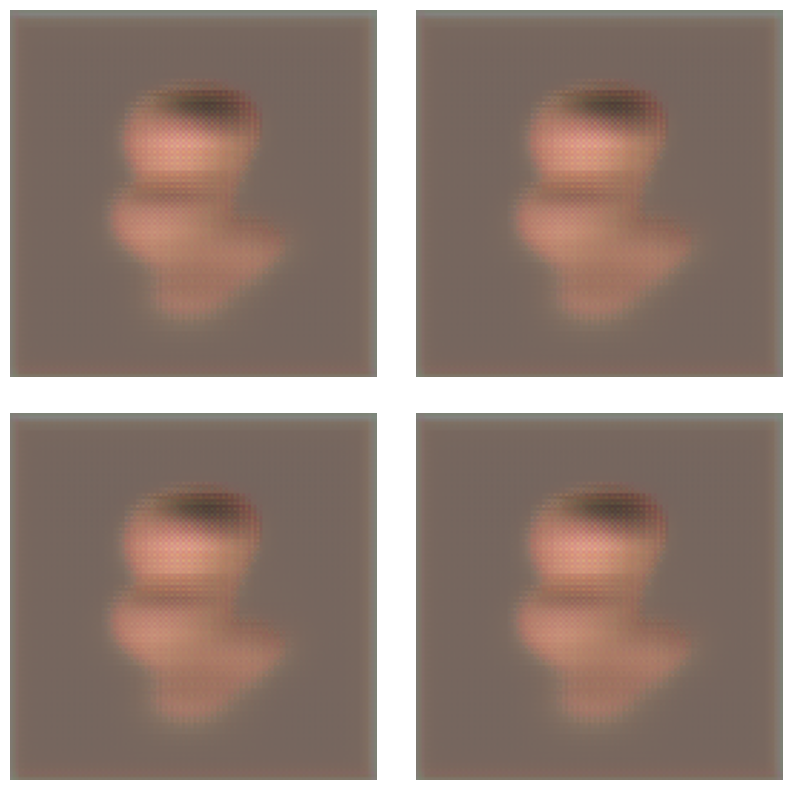

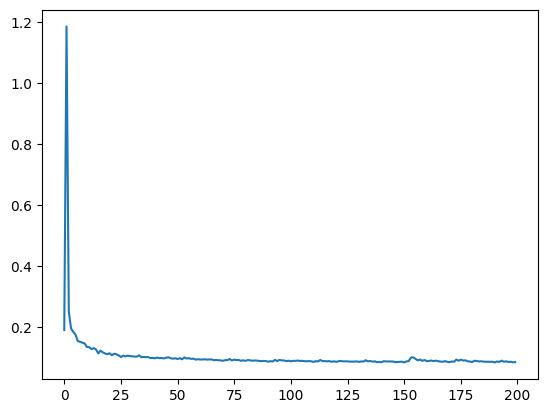

epoch: 11/100 - loss: 0.084413 - recon_loss: 0.084226- kl_loss: 0.000373: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 12/100 - loss: 0.083299 - recon_loss: 0.083147- kl_loss: 0.000303: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 13/100 - loss: 0.081506 - recon_loss: 0.081241- kl_loss: 0.000531: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 14/100 - loss: 0.081305 - recon_loss: 0.079510- kl_loss: 0.003591: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 15/100 - loss: 0.076240 - recon_loss: 0.070647- kl_loss: 0.011186: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 16/100 - loss: 0.065781 - recon_loss: 0.059347- kl_loss: 0.012868: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 17/100 - loss: 0.076156 - recon_loss: 0.071751- kl_loss: 0.008809: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
epoch: 18/100 - loss: 0.061744 - recon_loss: 0.053886- kl_loss: 0.015715: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 19/100 - loss: 0.

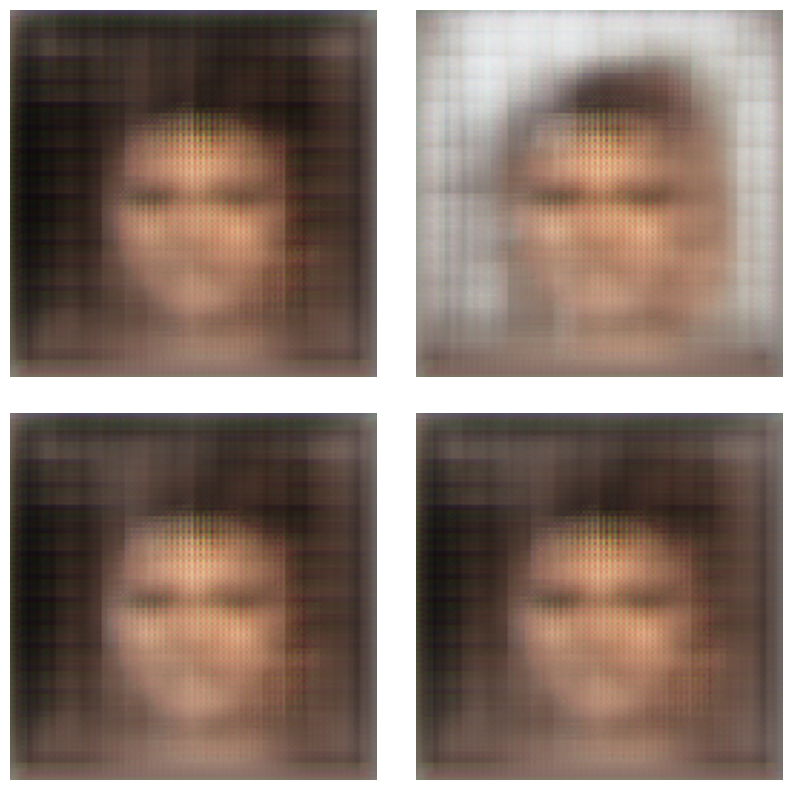

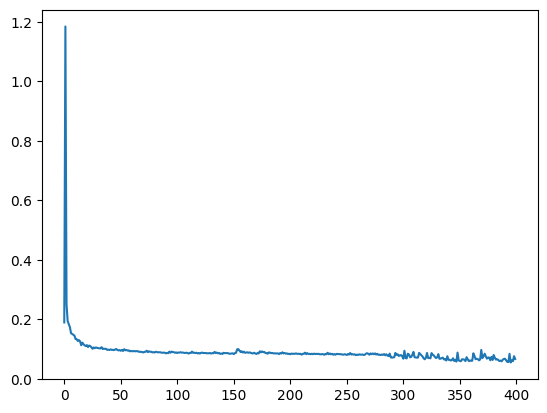

epoch: 21/100 - loss: 0.052847 - recon_loss: 0.047288- kl_loss: 0.011118: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 22/100 - loss: 0.058314 - recon_loss: 0.052090- kl_loss: 0.012447: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 23/100 - loss: 0.071074 - recon_loss: 0.058943- kl_loss: 0.024262: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 24/100 - loss: 0.048907 - recon_loss: 0.043416- kl_loss: 0.010982: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 25/100 - loss: 0.050601 - recon_loss: 0.043460- kl_loss: 0.014282: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 26/100 - loss: 0.052037 - recon_loss: 0.044966- kl_loss: 0.014143: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 27/100 - loss: 0.072065 - recon_loss: 0.066867- kl_loss: 0.010395: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 28/100 - loss: 0.058882 - recon_loss: 0.052683- kl_loss: 0.012398: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 29/100 - loss: 0.

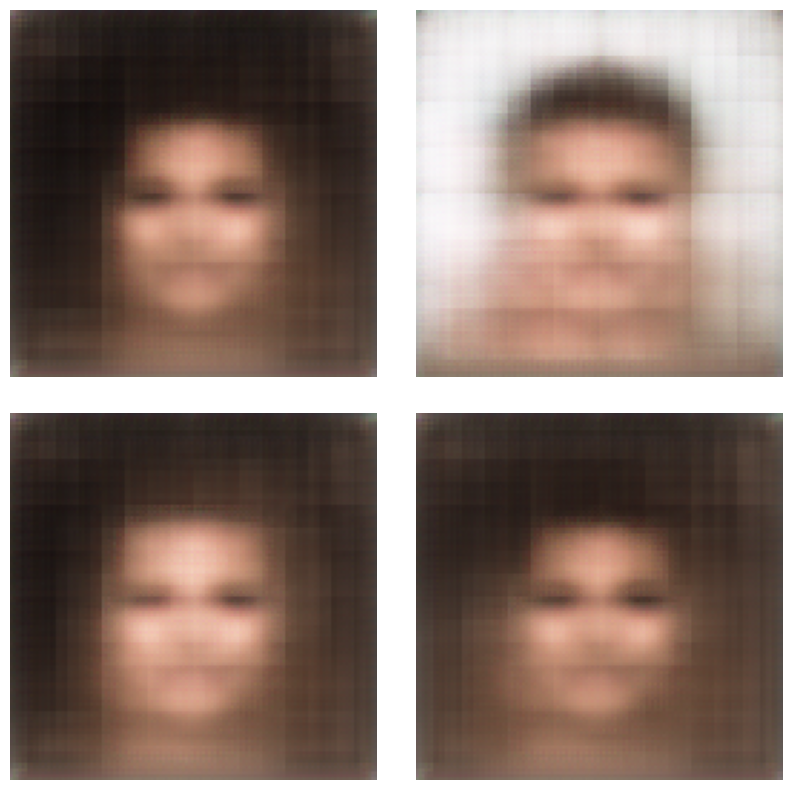

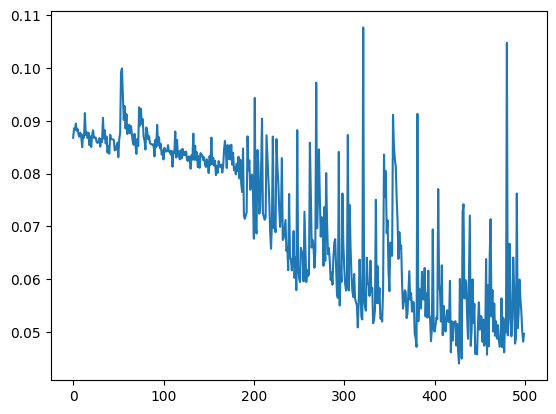

epoch: 31/100 - loss: 0.049791 - recon_loss: 0.042724- kl_loss: 0.014134: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 32/100 - loss: 0.055739 - recon_loss: 0.046221- kl_loss: 0.019037: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 33/100 - loss: 0.047757 - recon_loss: 0.043262- kl_loss: 0.008990: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 34/100 - loss: 0.046391 - recon_loss: 0.039121- kl_loss: 0.014542: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 35/100 - loss: 0.043729 - recon_loss: 0.037343- kl_loss: 0.012773: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 36/100 - loss: 0.055088 - recon_loss: 0.050456- kl_loss: 0.009265: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
epoch: 37/100 - loss: 0.044889 - recon_loss: 0.039195- kl_loss: 0.011389: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 38/100 - loss: 0.053507 - recon_loss: 0.047400- kl_loss: 0.012214: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]
epoch: 39/100 - loss: 0.

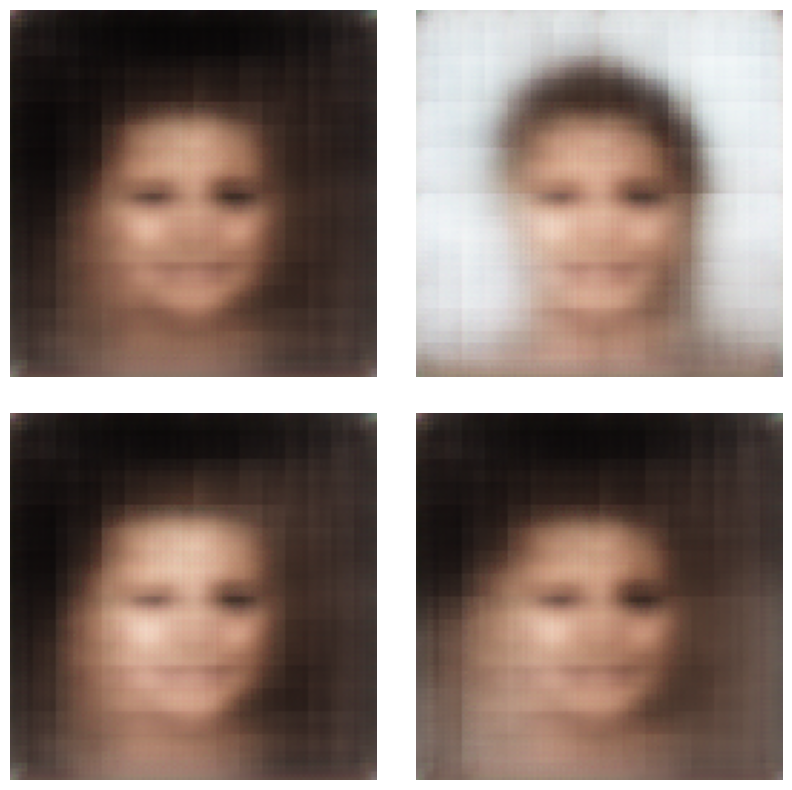

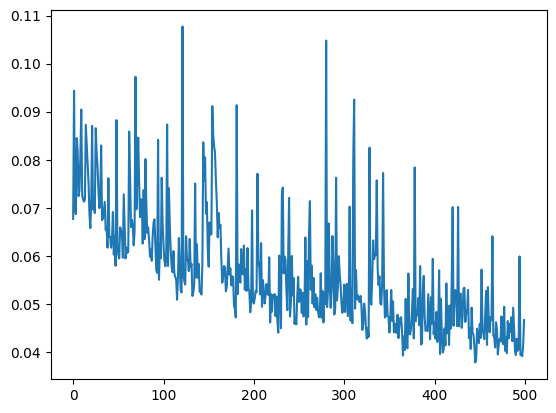

epoch: 41/100 - loss: 0.045372 - recon_loss: 0.041845- kl_loss: 0.007054: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]
epoch: 42/100 - loss: 0.062720 - recon_loss: 0.057650- kl_loss: 0.010140: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
epoch: 43/100 - loss: 0.040844 - recon_loss: 0.036974- kl_loss: 0.007740:  30%|███       | 6/20 [00:05<00:12,  1.17it/s]

In [ ]:
epochs = 500
history = []
vae.train()
for epoch in range(1, epochs + 1):
    bar = tqdm(data_loader)
    for x in bar:
        x = x.to(device)
        optimizer.zero_grad()
        x_pred, mean, logvar = vae(x)
        loss, recon_loss, kl_loss = vae_loss(mean, logvar, x, x_pred, .5)
        loss.backward()
        optimizer.step()
        
        history.append(loss.item())
        bar.set_description(
            f'epoch: {epoch}/{epochs} - loss: {history[-1]:.6f}' + \
            f' - recon_loss: {recon_loss.detach().cpu().item():.6f}' + \
            f' - kl_loss: {kl_loss.detach().cpu().item():.6f}'
        )
    if epoch % 5 == 0:
        plot_images(x_pred.detach().cpu().permute([0, 2, 3, 1])[:25], 5)
        plt.plot(history[-500:])
        plt.show()

In [ ]:
x_pred, mean, logvar = vae(x.to(device))
x_pred = x_pred.detach().cpu().numpy()
mean = mean.detach().cpu().numpy()
logvar = logvar.detach().cpu().numpy()
plt.scatter(mean[:, 0], mean[:, 1])

In [ ]:
torch.save(vae, 'vae.pt')